In [560]:
import pandas as pd
import json
import numpy as np

In [561]:
df_w1 = pd.read_csv("Raw/W1_AllAppsWide_2024-11-13-4.csv")
df_w1 = df_w1.query('`session.code` == "3m87qmko" | `session.code` == "wt9ndgb1"')
# Fix the missing label
df_w1.loc[df_w1["network_app.1.player.participantcode"] == "tfp", "network_app.1.player.participantcode"] = "tpf"

df_w2 = pd.read_csv("Raw/W2_all_apps_wide_2024-12-10-2.csv")
df_w2 = df_w2.query('`session.code` == "2n8orvug"')
df_w2["participant.label"][244] = "nan" # fixing the missing label

df_w3 = pd.read_csv("Raw/W3_all_apps_wide_2025-01-29.csv")
df_w3 = df_w3.query('`session.code` == "7uy8unkt"')
df_w3["participant.label"][46] = "nan" # fixing the missing label

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_1656/1169033480.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_w2["participant.label"][244] = "nan" # fixing the missing label
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/

In [562]:
def prep_function_w1(df):
    # Drop rows where 'network_app.1.player.participantcode' is NaN
    df = df.dropna(subset=['network_app.1.player.participantcode'])
    # Lowercase the 'network_app.1.player.participantcode' column
    df['network_app.1.player.participantcode'] = df['network_app.1.player.participantcode'].str.lower()


    # Identify duplicates based on 'network_app.1.player.participantcode'
    duplicates = df[df.duplicated(subset='network_app.1.player.participantcode', keep=False)]
    # Filter duplicates where 'participant._index_in_pages' > 15
    filtered_duplicates = duplicates[duplicates['participant._index_in_pages'] > 15]
    # Remove the duplicates from the original dataframe (only those where 'participantcode' is duplicated)
    df = df[~df['network_app.1.player.participantcode'].isin(duplicates['network_app.1.player.participantcode'])]
    # Concatenate the filtered duplicates back into the dataframe
    df = pd.concat([df, filtered_duplicates], axis=0, ignore_index=True)


    # Lowercase person columns ('network_app.1.player.person_1' to 'network_app.1.player.person_30')
    person_columns = [f'network_app.1.player.person_{i}' for i in range(1, 31)]
    df[person_columns] = df[person_columns].apply(lambda x: x.str.lower())
    # Replace missing values with 'x' in all person columns
    df[person_columns] = df[person_columns].fillna("x")

    for _, row in df.iterrows():
        # Other node and edge processing...
        # Check if participantcode and person_1 match
        if row["network_app.1.player.participantcode"] == row["network_app.1.player.person_1"]:
            df.loc[_, "network_app.1.player.linksrechts_self"] = row["network_app.1.player.linksrechts_1"]

    df['participant.label'] = df['network_app.1.player.participantcode']

    return df


In [563]:
def prep_function_w2(df):
    df = df.dropna(subset=['participant.label'])
    
    for i in range(1, 31):
        df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()

    df['network_app.1.player.person_3'] = df['network_app.1.player.person_3'].str.replace("ny4", "ny3", case=False, regex=False) #added because of commentary

    for i in range(1, 10):
        col = f"demographic_app.1.player.social_networks_{i}"
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Replace missing values with "x" in columns: 'network_app.1.player.person_1', 'network_app.1.player.person_2' and 28 other columns
    df = df.fillna({'network_app.1.player.person_1': "x", 'network_app.1.player.person_2': "x", 'network_app.1.player.person_3': "x", 'network_app.1.player.person_4': "x", 'network_app.1.player.person_5': "x", 'network_app.1.player.person_6': "x", 'network_app.1.player.person_7': "x", 'network_app.1.player.person_8': "x", 'network_app.1.player.person_9': "x", 'network_app.1.player.person_10': "x", 'network_app.1.player.person_11': "x", 'network_app.1.player.person_12': "x", 'network_app.1.player.person_13': "x", 'network_app.1.player.person_14': "x", 'network_app.1.player.person_15': "x", 'network_app.1.player.person_16': "x", 'network_app.1.player.person_17': "x", 'network_app.1.player.person_18': "x", 'network_app.1.player.person_19': "x", 'network_app.1.player.person_20': "x", 'network_app.1.player.person_21': "x", 'network_app.1.player.person_22': "x", 'network_app.1.player.person_23': "x", 'network_app.1.player.person_24': "x", 'network_app.1.player.person_25': "x", 'network_app.1.player.person_26': "x", 'network_app.1.player.person_27': "x", 'network_app.1.player.person_28': "x", 'network_app.1.player.person_29': "x", 'network_app.1.player.person_30': "x"})

    return df

In [564]:
def prep_function_w3(df):
    df = df.dropna(subset=['participant.label'])
    
    for i in range(1, 31):
        df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()

    df['network_app.1.player.person_3'] = df['network_app.1.player.person_3'].str.replace("ny4", "ny3", case=False, regex=False) #added because of commentary

    for i in range(1, 10):
        col = f"demographic_app.1.player.social_networks_{i}"
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Replace missing values with "x" in columns: 'network_app.1.player.person_1', 'network_app.1.player.person_2' and 28 other columns
    df = df.fillna({'network_app.1.player.person_1': "x", 'network_app.1.player.person_2': "x", 'network_app.1.player.person_3': "x", 'network_app.1.player.person_4': "x", 'network_app.1.player.person_5': "x", 'network_app.1.player.person_6': "x", 'network_app.1.player.person_7': "x", 'network_app.1.player.person_8': "x", 'network_app.1.player.person_9': "x", 'network_app.1.player.person_10': "x", 'network_app.1.player.person_11': "x", 'network_app.1.player.person_12': "x", 'network_app.1.player.person_13': "x", 'network_app.1.player.person_14': "x", 'network_app.1.player.person_15': "x", 'network_app.1.player.person_16': "x", 'network_app.1.player.person_17': "x", 'network_app.1.player.person_18': "x", 'network_app.1.player.person_19': "x", 'network_app.1.player.person_20': "x", 'network_app.1.player.person_21': "x", 'network_app.1.player.person_22': "x", 'network_app.1.player.person_23': "x", 'network_app.1.player.person_24': "x", 'network_app.1.player.person_25': "x", 'network_app.1.player.person_26': "x", 'network_app.1.player.person_27': "x", 'network_app.1.player.person_28': "x", 'network_app.1.player.person_29': "x", 'network_app.1.player.person_30': "x"})

    return df

In [565]:
df_w1 = prep_function_w1(df_w1)
df_w2 = prep_function_w2(df_w2)
df_w3 = prep_function_w3(df_w3)

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_1656/32931137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['network_app.1.player.participantcode'] = df['network_app.1.player.participantcode'].str.lower()
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_1656/2816499991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_1656/2816

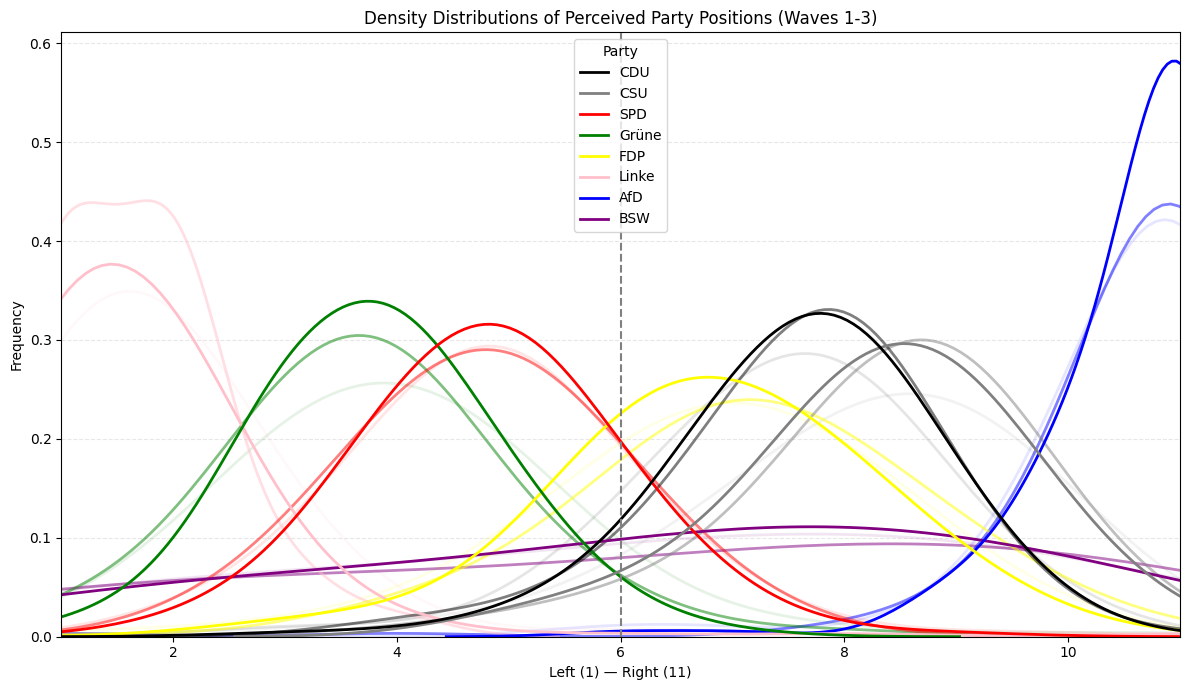

In [566]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define party columns and their colors
party_columns = [
    'political_app.1.player.lr_CDU',
    'political_app.1.player.lr_CSU',
    'political_app.1.player.lr_SPD',
    'political_app.1.player.lr_Gruene',
    'political_app.1.player.lr_FDP',
    'political_app.1.player.lr_Linke',
    'political_app.1.player.lr_AfD', 
    'political_app.1.player.lr_BSW', 
]

party_names = ['CDU', 'CSU', 'SPD', 'Grüne', 'FDP', 'Linke', 'AfD', 'BSW']
party_colors = {
    'CDU': 'black',
    'CSU': 'grey',
    'SPD': 'red',
    'Grüne': 'green',
    'FDP': 'yellow',
    'Linke': 'pink',
    'AfD': 'blue',
    'BSW': 'purple'
}

# Combine data from all waves
all_waves = []
for i, df_wave in enumerate([df_w1, df_w2, df_w3], start=1):
    party_df = df_wave[party_columns].copy().dropna()
    party_df.columns = party_names
    party_long = party_df.melt(var_name='Party', value_name='Left-Right Position')
    party_long['Wave'] = f'Wave {i}'
    all_waves.append(party_long)

combined_df = pd.concat(all_waves, ignore_index=True)
combined_df = combined_df[(combined_df['Left-Right Position'] >= 1) & (combined_df['Left-Right Position'] <= 11)]

plt.figure(figsize=(12, 7))

alphas = [0.1, 0.5, 1.0]  # alpha values for Wave 1, 2, 3 respectively

for i, wave in enumerate(sorted(combined_df['Wave'].unique())):
    sns.kdeplot(
        data=combined_df[combined_df['Wave'] == wave],
        x='Left-Right Position',
        hue='Party',
        hue_order=party_names,
        palette=party_colors,
        linewidth=2,
        common_norm=False,
        bw_adjust=1.9,
        alpha=alphas[i],
        legend=False
    )

plt.title('Density Distributions of Perceived Party Positions (Waves 1-3)')
plt.xlabel('Left (1) — Right (11)')
plt.ylabel('Frequency')
plt.axvline(x=6, color='gray', linestyle='--', linewidth=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xlim(1, 11)
plt.tight_layout()

# Legend for parties only
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=party_colors[p], lw=2) for p in party_names]
plt.legend(legend_handles, party_names, title='Party')

plt.show()


In [567]:
def shiny_dataframe(df):
    # Columns to drop
    drop_columns = [
        'participant._is_bot', 
        'participant._index_in_pages', 
        'conjoint_app.1.player.participant_label', 
        'conjoint_app.1.player.id_in_group',
        'participant._current_app_name', 
        'participant._current_page_name', 
        'conjoint_app.1.player.payoff', 
        'demographic_app.1.player.id_in_group',
        'participant.visited', 
        'participant.mturk_worker_id', 
        'participant.mturk_assignment_id',
        'participant.payoff', 
        'session.label', 
        'session.mturk_HITId', 
        'session.mturk_HITGroupId',
        'session.comment', 
        'session.is_demo', 
        'session.config.real_world_currency_per_point',
        'session.config.participation_fee', 
        'conjoint_app.1.player.language',
        'conjoint_app.1.group.id_in_subsession', 
        'conjoint_app.1.subsession.round_number',
        'demographic_app.1.player.role', 
        'demographic_app.1.player.payoff',
        'network_app.1.player.role', 
        'network_app.1.player.payoff',
        'demographic_app.1.group.id_in_subsession', 
        'demographic_app.1.subsession.round_number',
        'conjoint_app.1.player.role', 
        'session.config.name',
        'network_app.1.group.id_in_subsession', 
        'network_app.1.subsession.round_number',
        'political_app.1.player.role', 
        'political_app.1.player.id_in_group',
        'political_app.1.subsession.round_number', 
        'political_app.1.group.id_in_subsession',
        'end_app.1.player.role', 
        'end_app.1.player.payoff', 'end_app.1.player.group_assignment',
        'end_app.1.player.time_endpage', 'end_app.1.group.id_in_subsession',
        'end_app.1.subsession.round_number', 'political_app.1.player.payoff',
        'demographic_app.1.player.role',
        'end_app.1.player.rnumber',
        'end_app.1.player.rnumbercheck',
        'conjoint_app.1.player.time_start',
        'network_app.1.player.participantcode',
        'political_app.1.player.lr_CDU',
        'political_app.1.player.lr_CSU',
        'political_app.1.player.lr_SPD',
        'political_app.1.player.lr_Gruene',
        'political_app.1.player.lr_FDP',
        'political_app.1.player.lr_Linke',
        'political_app.1.player.lr_AfD', 
        'political_app.1.player.lr_BSW',
        'demographic_app.1.player.study_program_other',
    ]

    # Drop specified columns
    df = df.drop(columns=[col for col in drop_columns if col in df.columns])

    # Inconsistency in no answer variable
    df = df.replace(-888, -999)
    df = df.replace(-999, np.nan)
    df['network_app.1.player.linksrechts_self'] = df['network_app.1.player.linksrechts_self'].replace(0, np.nan)
    #df['demographic_app.1.player.study_program'] = df['demographic_app.1.player.study_program'].replace(np.nan, 0)

    # List of prefixes to keep
    prefixes = ['conjoint', 
                'demographic', 
                'political', 
                'vignette', 
                'participant.label', 
                'network_app.1.player.participantcode',
                'network_app.1.player.linksrechts_self',
                'end_app.1.player.catdog']   

    # Filter columns by prefixes
    df = df.loc[:, df.columns.str.startswith(tuple(prefixes))]
    
    ## Create Indexes
    # List of columns for the politics index
    politics_cols = [
        "political_app.1.player.politics_question_one",
        "political_app.1.player.politics_question_two",
        "political_app.1.player.politics_question_three",
        "political_app.1.player.politics_question_four",
        "political_app.1.player.politics_question_five",
        "political_app.1.player.politics_question_six",
        "political_app.1.player.politics_question_seven"
    ]
    # Replace -999 with 0 in these columns
    df[politics_cols] = df[politics_cols].replace(-999, 0)
    # Create index by taking the mean
    df['index_politics_question'] = df[politics_cols].mean(axis=1)
    
    try:
        df['demographic_app.1.player.petition_signatory'] = df["demographic_app.1.player.petition_signatory"].replace(2, 0)
        df["demographic_app.1.player.participation_demonstration"] = df["demographic_app.1.player.participation_demonstration"].replace(2, 0)
        df["political_app.1.player.sunday_poll"] = df["political_app.1.player.sunday_poll"].replace([2,3,4], 0)
        df['index_participation'] = df[['demographic_app.1.player.petition_signatory', 'demographic_app.1.player.participation_demonstration', "political_app.1.player.sunday_poll"]].sum(axis=1)
    except:
        pass

    scalo_to_index_1 = ['political_app.1.player.scalo_pep16', 'political_app.1.player.scalo_pep7', 'political_app.1.player.scalo_pep10']
    df['index_int_criminal_scalo'] = df[scalo_to_index_1].mean(axis=1)

    scalo_to_index_2 = ['political_app.1.player.scalo_pep13', 'political_app.1.player.scalo_pep8', 'political_app.1.player.scalo_pep4', 'political_app.1.player.scalo_pep1', 'political_app.1.player.scalo_pep3']
    df['index_government_scalo'] = df[scalo_to_index_2].mean(axis=1)

    scalo_to_index_3 = ['political_app.1.player.scalo_pep5', 'political_app.1.player.scalo_pep11', 'political_app.1.player.scalo_pep12', 'political_app.1.player.scalo_pep14', 'political_app.1.player.scalo_pep15']
    df['index_opposition_scalo'] = df[scalo_to_index_3].mean(axis=1)   

    scalo_to_index_4 = ['political_app.1.player.scalo_pep6', 'political_app.1.player.scalo_pep2', 'political_app.1.player.scalo_pep9', 'political_app.1.player.scalo_pep14']
    df['index_int_goodies_scalo'] = df[scalo_to_index_4].mean(axis=1)   

    scalo_to_index_5 = ['political_app.1.player.scalo_spd', 'political_app.1.player.scalo_gruene', 'political_app.1.player.scalo_linke']
    df['index_left_party_scalo'] = df[scalo_to_index_5].mean(axis=1)  
    
    scalo_to_index_6 = ['political_app.1.player.scalo_cdu', 'political_app.1.player.scalo_csu', 'political_app.1.player.scalo_fdp', 'political_app.1.player.scalo_afd']
    df['index_right_party_scalo'] = df[scalo_to_index_6].mean(axis=1)  

    df = df.fillna({'political_app.1.player.sunday_party_vote': 0})

    # Drop specified columns
    df = df.drop(columns=[col for col in politics_cols if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_1 if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_2 if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_3 if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_4 if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_5 if col in df.columns])
    df = df.drop(columns=[col for col in scalo_to_index_6 if col in df.columns])

    df = df.drop(columns=[col for col in ['demographic_app.1.player.participation_demonstration', 
                                          'demographic_app.1.player.participation_demonstration_1', 
                                          'demographic_app.1.player.petition_signatory', 
                                          'demographic_app.1.player.petition_signatory_1',
                                          'political_app.1.player.sunday_poll', 
                                          'political_app.1.player.sunday_not_eligible', 
                                          'political_app.1.player.noteligible_sunday_party_vote',
                                          'political_app.1.player.reason_no_vote'] if col in df.columns])

    return df

In [568]:
df_filtered_w1 = shiny_dataframe(df_w1)
df_filtered_w2 = shiny_dataframe(df_w2)
df_filtered_w3 = shiny_dataframe(df_w3)

# Export dataframes as CSV
df_filtered_w1.to_csv('Cooked/df_w1_prepared.csv', index=False)
df_filtered_w2.to_csv('Cooked/df_w2_prepared.csv', index=False)
df_filtered_w3.to_csv('Cooked/df_w3_prepared.csv', index=False)

In [580]:
df_filtered_w1

,participant.label,conjoint_app.1.player.device_type,conjoint_app.1.player.operating_system,conjoint_app.1.player.browser,conjoint_app.1.player.lang,conjoint_app.1.player.use_of_device,demographic_app.1.player.rent,demographic_app.1.player.income,demographic_app.1.player.edu_father,demographic_app.1.player.edu_mother,...,network_app.1.player.linksrechts_self,political_app.1.player.sunday_party_vote,political_app.1.player.scalo_bsw,index_politics_question,index_int_criminal_scalo,index_government_scalo,index_opposition_scalo,index_int_goodies_scalo,index_left_party_scalo,index_right_party_scalo
2,kru,3.0,2.0,3.0,0.0,1.0,NaN,NaN,1.0,1.0,...,NaN,3.0,-3.0,3.142857,-3.666667,0.4,-2.8,0.25,1.000000,-1.75
3,4yx,2.0,5.0,3.0,0.0,3.0,NaN,NaN,1.0,1.0,...,NaN,3.0,-4.0,3.571429,-3.333333,2.4,-4.2,0.25,2.333333,-2.75
4,qew,3.0,2.0,3.0,0.0,1.0,NaN,NaN,4.0,4.0,...,1.0,5.0,-5.0,4.142857,-5.000000,-0.8,-4.6,-1.25,0.666667,-4.75
5,k9w,3.0,2.0,3.0,0.0,1.0,NaN,NaN,4.0,4.0,...,5.0,3.0,-5.0,3.857143,-5.000000,1.2,-3.8,-0.25,1.000000,-1.25
6,3ab,3.0,2.0,3.0,0.0,1.0,NaN,NaN,4.0,4.0,...,NaN,1.0,-4.0,4.000000,-4.333333,1.2,-3.8,0.25,1.000000,-2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,ytr,3.0,2.0,3.0,0.0,2.0,NaN,NaN,4.0,4.0,...,8.0,6.0,-2.0,3.428571,2.000000,-2.6,0.0,-1.00,-4.333333,0.50
173,sbf,3.0,2.0,3.0,0.0,2.0,NaN,NaN,4.0,1.0,...,NaN,2.0,-1.0,3.000000,-2.000000,2.6,1.6,3.25,1.333333,1.25
176,cyw,2.0,4.0,3.0,0.0,3.0,NaN,NaN,1.0,4.0,...,5.0,8.0,-4.0,2.285714,-5.000000,-2.4,-4.4,-1.50,-3.333333,-3.75
177,dxp,3.0,2.0,3.0,0.0,1.0,NaN,NaN,1.0,1.0,...,3.0,3.0,-4.0,3.571429,-4.666667,-1.2,-4.6,-2.00,-1.000000,-4.00


***

## Merging Waves for Complete Dataframe

Filling the different waves with information from other waves

In [570]:
# 1. Prepare DataFrames with consistent column naming
dfs = {
    'W1': df_w1.rename(columns=lambda x: f"{x}_W1" if x != "participant.label" else x),
    'W2': df_w2.rename(columns=lambda x: f"{x}_W2" if x != "participant.label" else x),
    'W3': df_w3.rename(columns=lambda x: f"{x}_W3" if x != "participant.label" else x)
}

# 2. Merge all waves in a single operation
merged_df = dfs['W1'].merge(
    dfs['W2'], 
    how='outer', 
    on='participant.label'
).merge(
    dfs['W3'], 
    how='outer', 
    on='participant.label'
)

# 3. Drop unwanted columns
merged_df = merged_df.drop(columns=[
    'demographic_app.1.player.rent_W1',
    'demographic_app.1.player.income_W1'
])

# 4. Categorize participants
all_participants = set(merged_df['participant.label'])
complete = set(dfs['W1']['participant.label']) & set(dfs['W2']['participant.label']) & set(dfs['W3']['participant.label'])
partial = all_participants - complete

# 5. Create complete cases DataFrame
complete_df = merged_df[merged_df['participant.label'].isin(complete)].copy()
complete_df.set_index('participant.label', inplace=True)

# 6. Forward/backward fill between waves in a more efficient way
suffix_pairs = [('_W1', '_W2'), ('_W2', '_W3'), ('_W1', '_W3')]

for src_suffix, target_suffix in suffix_pairs:
    for col in complete_df.filter(like=src_suffix).columns:
        target_col = col.replace(src_suffix, target_suffix)
        if target_col in complete_df:
            complete_df[col] = complete_df[col].fillna(complete_df[target_col])
            complete_df[target_col] = complete_df[target_col].fillna(complete_df[col])

# 7. Split by wave function (simplified)
def split_by_wave(df, suffix):
    cols = [c for c in df.columns if c.endswith(suffix) or c == 'participant.label']
    wave_df = df[cols].copy()
    wave_df.columns = [c.replace(suffix, '') for c in wave_df.columns]
    return wave_df

# 8. Create final wave DataFrames
wave_dfs = {
    'W1': split_by_wave(complete_df.reset_index(), '_W1'),
    'W2': split_by_wave(complete_df.reset_index(), '_W2'),
    'W3': split_by_wave(complete_df.reset_index(), '_W3')
}

# 9. Create partial cases DataFrame (if needed)
partial_df = merged_df[merged_df['participant.label'].isin(partial)].copy()

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_1656/3337107549.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  complete_df[col] = complete_df[col].fillna(complete_df[target_col])


***
## Network Dictionaries
`dict_nodes = {participant_label : {participant_attributes : values, network_app.1.player.person_1...30 : {Friends : True, Politics : True}}}`

In [571]:
def create_nodes(df, unique_id, wave=None):
    """
    Create a dictionary of nodes from a DataFrame with attributes for each node.
    Skips attributes with missing/invalid values instead of including them as NaN.
    
    Parameters:
    - df: pandas DataFrame containing node data
    - unique_id: column name that serves as the node identifier
    - wave: optional wave identifier to add to attribute names
    
    Returns:
    - Dictionary of dictionaries {node_id: {attribute1: value1, ...}}
    """
    # Validate inputs
    if unique_id not in df.columns:
        raise ValueError(f"Column '{unique_id}' not found in DataFrame")
    
    # Initialize nodes dictionary
    nodes = {}
    
    # Process each row
    for _, row in df.iterrows():
        node_id = row[unique_id]
        node_attrs = {}
        
        # Process each column
        for col in df.columns:
            if col == unique_id:
                continue
                
            # Get the value
            value = row[col]
            
            # Skip if value is missing or invalid
            if pd.isna(value) or value in ["", -999]:
                continue
                
            # Create attribute name
            attr_name = col.split('.')[-1]
            
            # Optional: add wave suffix if provided
            if wave is not None:
                attr_name = f"{attr_name}"
                
            node_attrs[attr_name] = value
        
        # Only add node if it has at least one attribute
        # (or remove this check if you want nodes even with no attributes)
        if node_attrs:
            nodes[node_id] = node_attrs
    
    return nodes

In [572]:
def replace_missing_with_default(value, default_value=np.nan):
    if pd.isna(value) or value in [""]:
        return default_value
    return value

def create_edges(df, unique_id, dict_nodes):
    dict_edges = {label: {} for label in df[unique_id]}
    dropped = 0
    list_dropped = []
    edge_info = {
        "friend": 0,
        "value": 0,
        "politics": 0,
        "study": 0,
        "council": 0,
        "leftright": 0,
        "sentiment": 0,
        "aquaintance": 0
    }

    # Iterate through rows to populate edge attributes
    for _, row in df.iterrows():
        label = row[unique_id]
        for i in range(1, 30):
            target_person = row[f"network_app.1.player.person_{i}"]
            if target_person != "x" and target_person != label:
                if target_person in dict_nodes:
                    leftright_value = replace_missing_with_default(row[f"network_app.1.player.linksrechts_{i}"])
                    
                    # Only include leftright if the value is not 0
                    edge_data = {
                        "aquaintance": True,
                        "friend": replace_missing_with_default(row[f"network_app.1.player.friend_{i}"]) == 1,
                        "value": replace_missing_with_default(row[f"network_app.1.player.value_{i}"]) == 1,
                        "politics": replace_missing_with_default(row[f"network_app.1.player.politics_{i}"]) == 1,
                        "study": replace_missing_with_default(row[f"network_app.1.player.study_{i}"]) == 1,
                        "council": replace_missing_with_default(row[f"network_app.1.player.council_{i}"]) == 1
                    }
                    
                    if leftright_value != 0:  # Only add leftright if value is not 0
                        edge_data["leftright"] = leftright_value
                        edge_info["leftright"] += 1  # Only count non-zero leftright values
                    
                    dict_edges[label][target_person] = edge_data
                    
                    try:
                        sentiment_value = replace_missing_with_default(row[f"network_app.1.player.sentiment_{i}"])
                        if not pd.isna(sentiment_value):  # Only add sentiment if it's not NaN
                            dict_edges[label][target_person]["sentiment"] = sentiment_value
                            edge_info["sentiment"] += 1
                    except KeyError:
                        pass

                    # Update edge information counts
                    edge_info["friend"] += dict_edges[label][target_person]["friend"]
                    edge_info["value"] += dict_edges[label][target_person]["value"]
                    edge_info["politics"] += dict_edges[label][target_person]["politics"]
                    edge_info["study"] += dict_edges[label][target_person]["study"]
                    edge_info["council"] += dict_edges[label][target_person]["council"]
                    edge_info["aquaintance"] += 1
                else:
                    # Log dropped connections
                    dropped += 1
                    list_dropped.append(target_person)

    return dict_edges, edge_info, list_dropped

In [573]:
def data_extraction(df_nodes, df_edges, unique_id, wave):
    # Create nodes
    dict_nodes = create_nodes(df_nodes, unique_id, wave)
    
    # Create edges
    dict_edges, edge_info, list_dropped = create_edges(df_edges, unique_id, dict_nodes)

    # Save nodes and edges to JSON files
    with open(f'NA/nodes_{wave}.json', 'w') as json_file:
        json.dump(dict_nodes, json_file, indent=4)

    with open(f'NA/edges_{wave}.json', 'w') as json_file:
        json.dump(dict_edges, json_file, indent=4)

    # Print edge information summary
    print(f"Edge information for wave {wave}:")
    for key, value in edge_info.items():
        print(f"{key}: {value}")

    sum_edges = sum(len(edges) for edges in dict_edges.values())
    print("Amount of Edges dropped:", len(list_dropped))

    return dict_nodes, dict_edges, list_dropped

In [574]:
# Keep only complete observations
df_filtered_w1 = df_filtered_w1[df_filtered_w1['participant.label'].isin(complete)]
df_filtered_w2 = df_filtered_w2[df_filtered_w2['participant.label'].isin(complete)]
df_filtered_w3 = df_filtered_w3[df_filtered_w3['participant.label'].isin(complete)]

In [575]:
dict_nodes_w1, dict_edges_w1, list_dropped_w1 = data_extraction(df_filtered_w1, wave_dfs["W1"], 'participant.label', "W1")

Edge information for wave W1:
friend: 338
value: 253
politics: 228
study: 260
council: 327
leftright: 591
sentiment: 0
aquaintance: 599
Amount of Edges dropped: 79


In [576]:
dict_nodes_w2, dict_edges_w2, list_dropped_w2 = data_extraction(df_filtered_w2, wave_dfs["W2"], "participant.label", "W2")

Edge information for wave W2:
friend: 361
value: 235
politics: 210
study: 187
council: 317
leftright: 586
sentiment: 589
aquaintance: 589
Amount of Edges dropped: 88


In [577]:
dict_nodes_w3, dict_edges_w3, list_dropped_w3 = data_extraction(df_filtered_w3, wave_dfs["W3"], "participant.label", "W3")

Edge information for wave W3:
friend: 352
value: 262
politics: 219
study: 195
council: 338
leftright: 601
sentiment: 601
aquaintance: 601
Amount of Edges dropped: 53


In [578]:
import json
import networkx as nx

# Function to process the graph creation
def process_graph(edges_file, nodes_file, multiplex_filename):
    # Load data_WS2425 from JSON files
    with open(edges_file, 'r') as json_file:
        edges_dict = json.load(json_file)

    with open(nodes_file, 'r') as json_file:
        nodes_dict = json.load(json_file)

    # Create the directed multigraph (multiplex) and add edges for each type
    G_multi = nx.MultiDiGraph()
    edge_types = ["aquaintance", "leftright", "sentiment", "friend", "value", "politics", "study", "council"]
    for source, targets in edges_dict.items():
        for target, edge_attributes in targets.items():
            for edge_type in edge_types:
                if edge_type in edge_attributes:
                    if edge_type in ["friend", "value", "politics", "study", "council", "aquaintance"]:
                        if edge_attributes[edge_type]:
                            G_multi.add_edge(source, target, key=edge_type,type=edge_type)
                    elif edge_type == "leftright" and edge_attributes[edge_type] is not None and edge_attributes[edge_type] != 0:
                        G_multi.add_edge(source, target, key=edge_type, type=edge_type, weight=edge_attributes[edge_type])
                    elif edge_type == "sentiment" and edge_attributes[edge_type] is not None:
                        G_multi.add_edge(source, target, key=edge_type, type=edge_type, weight=edge_attributes[edge_type])

    # Add node-specific attributes to the multiplex graph
    for node, attributes in nodes_dict.items():
        G_multi.add_node(node, **attributes)

    # Write the multiplex graph to a GML file
    nx.write_gml(G_multi, multiplex_filename)
    print(f"Multiplex graph '{multiplex_filename}' created with {len(G_multi.nodes)} nodes and {len(G_multi.edges)} edges.")

# Process W2 and W1 datasets
process_graph(
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/edges_W1.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/nodes_W1.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w1.gml'
)

process_graph(
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/edges_W2.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/nodes_W2.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w2.gml'
)

process_graph(
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/edges_W3.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/nodes_W3.json',
    '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w3.gml'
)

Multiplex graph '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w1.gml' created with 154 nodes and 2587 edges.
Multiplex graph '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w2.gml' created with 154 nodes and 3074 edges.
Multiplex graph '/Users/ramius/Desktop/CodeVault/01_Project/Work/Susumu/Student_Survey/StudentSurvey_GitDock/data_WS2425/NA/multiplex_graph_w3.gml' created with 154 nodes and 3169 edges.
